In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import random
from joblib import dump, load
import gzip
import msgpack
import sys
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import msgpack
import gzip
import io
import numpy as np
import joblib
import zlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import copy
import joblib
import zlib
import msgpack
import gzip
import io
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.DataFrame()
for i in range(1, 11):
    df1 = pd.DataFrame()
    df1 = pd.read_csv(f'/content/drive/MyDrive/BTP-DataSets/MHEALTHDATASET/mHealth_subject{i}.log', header=None, sep='\t')
    df1 = df1.rename(columns={0: "acx", 1: "acy", 2: "acz", 3: "es1", 4: "es2",
                              5: "alx", 6: "aly", 7: "alz", 8: "glx", 9: "gly", 10: "glz", 11: "mlx", 12: "mly",
                              13: "mlz", 14: "arx", 15: "ary", 16: "arz", 17: "grx", 18: "gry", 19: "grz", 20: "mrx",
                              21: "mry", 22: "mrz", 23: "Activity"})
    df = pd.concat([df, df1])

<Axes: >

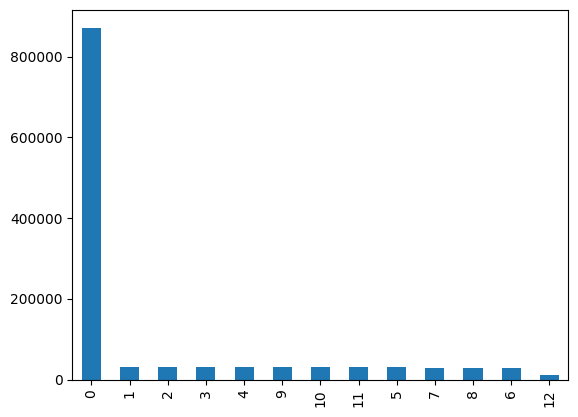

In [3]:
pd.value_counts(df['Activity']).plot.bar()

In [4]:
from sklearn.utils import resample

df_majority = df[df.Activity==0]
df_minorities = df[df.Activity!=0]

df_majority_downsampled = resample(df_majority,n_samples=30000, random_state=50)
df = pd.concat([df_majority_downsampled, df_minorities])
df.Activity.value_counts()

1     30720
2     30720
3     30720
4     30720
9     30720
10    30720
11    30720
5     30720
0     30000
7     29441
8     29337
6     28315
12    10342
Name: Activity, dtype: int64

In [5]:
num_of_clusters = 5
clusters_df=[]
for _ in range(num_of_clusters):
    clusters_df.append(df.sample(100000, replace=False))
cluster_heads=np.array([-1,-1,-1,-1,-1])

In [6]:
workers_info = []
energy_for_edge_at_start = 100000

# data, cluster no, edge score, model - coeff, model - intercept, energy consumed, acc
for i in range(5):
    for j in range(5):
        worker_data = pd.DataFrame(clusters_df[i].sample(30000, replace=False))
        worker_id = i
        worker_score = 0
        worker_coef = 0
        worker_intercept = 0
        worker_energy = []
        energy_acc = []
        energy = energy_for_edge_at_start
        workers_info.append([worker_data, worker_id, worker_coef, worker_score,
                             worker_intercept, worker_energy, energy_acc, energy])

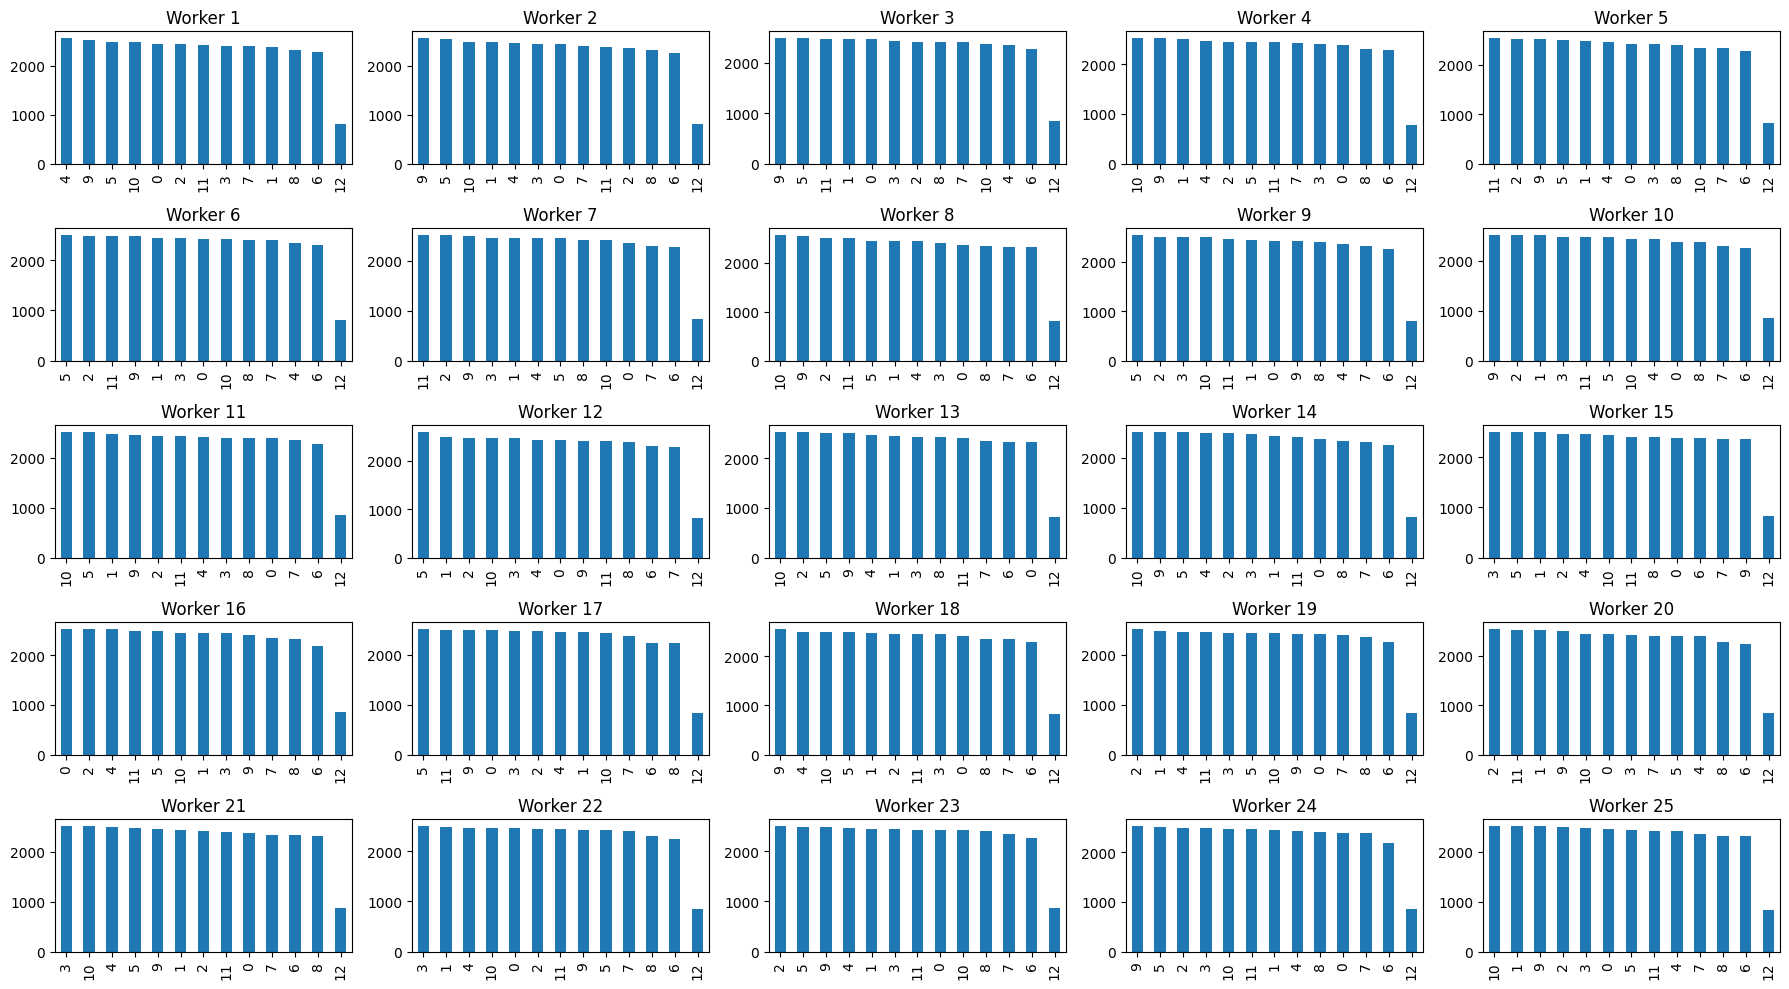

In [7]:
fig = plt.figure(figsize=(18, 10))
for i, worker in enumerate(workers_info):
    ax = fig.add_subplot(5, 5, i + 1)
    pd.value_counts(worker[0]['Activity']).plot.bar(ax=ax)
    ax.set_title(f'Worker {i + 1}')
fig.tight_layout()
plt.show()

In [8]:
import msgpack
import gzip
import io
import numpy as np
import joblib
import zlib

def extract(message):
    if message is None:
        return None, None

    try:
        # Use joblib.load to handle non-compressed models
        model = joblib.load(io.BytesIO(message))
        return model, None
    except Exception:
        pass

    try:
        # Handle gzipped models
        decompressed_byte_array = zlib.decompress(message)
        model = joblib.load(io.BytesIO(decompressed_byte_array))
        return model, None
    except Exception:
        pass

    # Return default values if extraction fails
    return None, None


def compress(model):
    try:
        # Save the model to a BytesIO object using joblib.dump
        model_bytesio = io.BytesIO()
        joblib.dump(model, model_bytesio)

        # Get the serialized model bytes
        model_bytes = model_bytesio.getvalue()

        # Compress the serialized model using gzip
        compressed_model = gzip.compress(model_bytes)

        # Store the compressed model in a MessagePack container
        message_pack_container = msgpack.packb([compressed_model])
        return message_pack_container
    except Exception:
        return None


In [9]:
max_rounds = 100  # Maximum number of training rounds
req_accuracy = 0.80  # Minimum accuracy threshold
negligible_change = 0.0001  # Change in accuracy to be considered negligible
energy_for_each_iteration=0.01
num_of_workers=25
def energy_for_transmit(data):
    power = 1
    # energy = power * time = time = data / power = data
    return data

def terminate(accuracy, best_accuracy):
    if accuracy >= req_accuracy or abs(accuracy - best_accuracy) < negligible_change:
        return True
    return False

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import copy

def local_worker_training(worker_num, global_model):
    # Shuffle the data before splitting
    workers_info[worker_num][0] = workers_info[worker_num][0].sample(frac=1, random_state=42)

    ltrain, ltest = train_test_split(workers_info[worker_num][0], test_size=0.2, random_state=42)
    lX_train = ltrain.drop('Activity', axis=1)
    ly_train = ltrain['Activity']
    lX_test = ltest.drop('Activity', axis=1)
    ly_test = ltest['Activity']

    # Use StandardScaler to scale the input features
    scaler = StandardScaler()
    lX_train_scaled = scaler.fit_transform(lX_train)
    lX_test_scaled = scaler.transform(lX_test)

    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Initialize variables before the if-else block
    energy_consumption_in_local = 0

    if worker_num in cluster_heads and workers_info[worker_num][2] is not None:
        energy_consumption_in_local = energy_for_transmit(sys.getsizeof(workers_info[worker_num][5]) +
                                                          sys.getsizeof(workers_info[worker_num][6]))

        # If the global model coefficients are available, set them during training
        sample_weights, _ = extract(workers_info[worker_num][2])

        if sample_weights is not None:
            sample_weights = np.ones(len(lX_train_scaled)) if sample_weights.size != len(lX_train_scaled) else sample_weights
            model.fit(lX_train_scaled, ly_train, sample_weight=sample_weights)
        else:
            model.fit(lX_train_scaled, ly_train)

        if sample_weights is not None and sample_weights.size > 1 and sample_weights.shape[0] != len(lX_train_scaled):
            sample_weights = np.repeat(sample_weights, len(lX_train_scaled) // len(sample_weights) + 1)[:len(lX_train_scaled)]

    else:
        model.fit(lX_train_scaled, ly_train)

    accuracy = model.score(lX_test_scaled, ly_test)

    energy_consumption_in_local += max_rounds * energy_for_each_iteration
    workers_info[worker_num][5].append(energy_consumption_in_local)
    workers_info[worker_num][6].append(accuracy)
    workers_info[worker_num][7] -= energy_consumption_in_local

    print("local worker:", worker_num, "acc:", accuracy, "round no:", max_rounds,
          "energy remaining:", workers_info[worker_num][7])


In [13]:
def training_workers(global_model=None):
    for i in range(num_of_workers):
        local_worker_training(i, global_model)

In [14]:
def cal_batter_life(energy_rem):
    return (energy_rem / energy_for_edge_at_start) * 100


In [15]:
# Modify the cal_edge_score function
def cal_edge_score():
    w1=0.4
    w2=0.6
    for i in range(num_of_workers):
        workers_info[i][3]=w1*workers_info[i][6][-1]+w2*cal_batter_life(workers_info[i][7])


# Modify the cal_clusters_head function
def cal_clusters_head():
    for i in range(5):
        max_score_edge=i*5
        for j in range(1,5):
            if workers_info[i*5+j][3]>workers_info[max_score_edge][3]:
	            max_score_edge=i*5+j
        cluster_heads[i]=max_score_edge


In [31]:
from sklearn.linear_model import LogisticRegression
import copy

def global_aggregation(global_model):
    training_workers(global_model)  # Pass the current global_model
    cal_edge_score()
    cal_clusters_head()

    # Use Logistic Regression instead of RandomForestClassifier
    if global_model is None:
        global_model = LogisticRegression(random_state=42)

    # Extract the coefficients and intercept from the existing global_model
    aggregated_coefs = copy.deepcopy(global_model.coef_) if hasattr(global_model, 'coef_') else []
    aggregated_intercept = copy.deepcopy(global_model.intercept_) if hasattr(global_model, 'intercept_') else 0

    num_contributing_workers = 0

    for i in range(num_of_clusters):
        worker_model, _ = extract(workers_info[i][2])  # extract returns a tuple

        if worker_model:
            # Extract the coefficients and intercept from the worker's Logistic Regression model
            coefs = worker_model.coef_
            intercept = worker_model.intercept_

            # Aggregate the coefficients
            if num_contributing_workers == 0:
                # If it's the first worker, simply copy the coefficients and intercept
                aggregated_coefs = copy.deepcopy(coefs)
                aggregated_intercept = copy.deepcopy(intercept)
            else:
                # Aggregate subsequent coefficients and intercept
                aggregated_coefs += coefs
                aggregated_intercept += intercept

            num_contributing_workers += 1

    # Normalize the aggregated coefficients and intercept by dividing by the number of contributing workers
    if num_contributing_workers > 0:
        aggregated_coefs /= num_contributing_workers
        aggregated_intercept /= num_contributing_workers

    # Set the aggregated coefficients and intercept to the global_model
    global_model.coef_ = aggregated_coefs
    global_model.intercept_ = aggregated_intercept

    return global_model


In [ ]:
max_global_rounds = 15
acc = []
global_model = None  # Initialize global_model outside the loop

for i in range(max_global_rounds):
    global_model = global_aggregation(global_model)  # Pass the current global_model
    compressed_model = compress(global_model)

    temp_max_acc = 0
    for j in range(num_of_workers):
        # Ensure there are enough recorded accuracies for each worker
        if len(workers_info[j][6]) > i and workers_info[j][6][i] is not None:
            workers_info[j][2] = compressed_model
            temp_max_acc = max(temp_max_acc, workers_info[j][6][i])

    acc.append(temp_max_acc)
    print("round - global", i, "acc", temp_max_acc)


local worker: 0 acc: 0.9485 round no: 100 energy remaining: 99991.0
local worker: 1 acc: 0.954 round no: 100 energy remaining: 99753.0
local worker: 2 acc: 0.9516666666666667 round no: 100 energy remaining: 99993.0
local worker: 3 acc: 0.9533333333333334 round no: 100 energy remaining: 99753.0
local worker: 4 acc: 0.9478333333333333 round no: 100 energy remaining: 99993.0
local worker: 5 acc: 0.9528333333333333 round no: 100 energy remaining: 99753.0
local worker: 6 acc: 0.954 round no: 100 energy remaining: 99993.0
local worker: 7 acc: 0.9525 round no: 100 energy remaining: 99994.0
local worker: 8 acc: 0.95 round no: 100 energy remaining: 99995.0
local worker: 9 acc: 0.9526666666666667 round no: 100 energy remaining: 99820.0
local worker: 10 acc: 0.9525 round no: 100 energy remaining: 99996.0
local worker: 11 acc: 0.9506666666666667 round no: 100 energy remaining: 99996.0
local worker: 12 acc: 0.9555 round no: 100 energy remaining: 99820.0
local worker: 13 acc: 0.9501666666666667 roun

In [33]:
total_energy_per_round=[]
energy_per_round=[]
total_energy=0
for i in range(15):
    energy=0
    for j in range(num_of_workers):
        total_energy+=workers_info[j][5][i]
        energy+=workers_info[j][5][i]
    energy_per_round.append(energy)
    total_energy_per_round.append(total_energy)
energy_per_round

[25.0,
 201.0,
 377.0,
 729.0,
 729.0,
 985.0,
 1465.0,
 1225.0,
 1225.0,
 1129.0,
 2233.0,
 2233.0,
 1865.0,
 1865.0,
 1497.0]

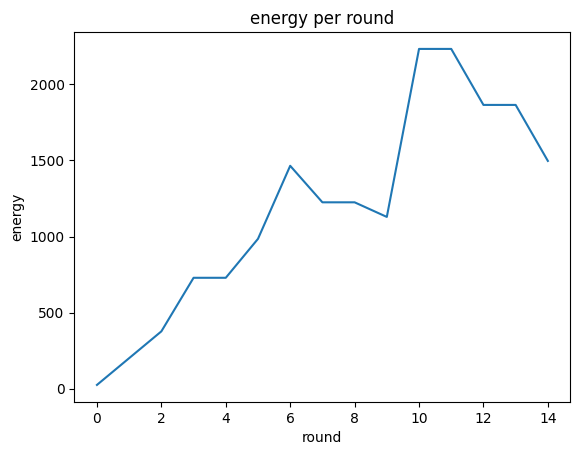

In [34]:
plt.plot(energy_per_round)
plt.xlabel("round")
plt.ylabel("energy")
plt.title("energy per round")
plt.show()

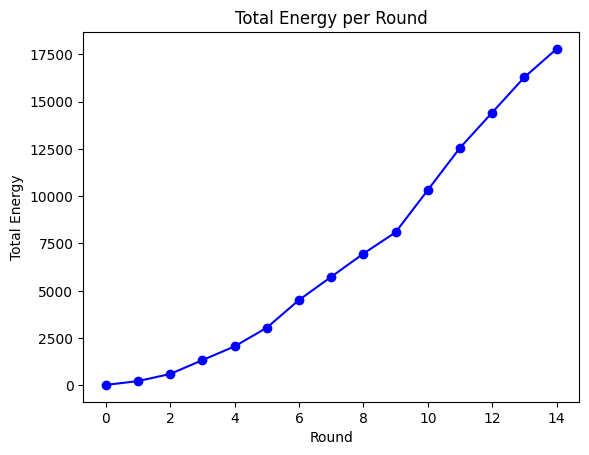

In [35]:
import matplotlib.pyplot as plt

# Assuming total_energy_per_round is already defined
plt.plot(total_energy_per_round, marker='o', linestyle='-', color='b')  # Customize markers, linestyle, and color
plt.xlabel("Round")
plt.ylabel("Total Energy")
plt.title("Total Energy per Round")
plt.show()


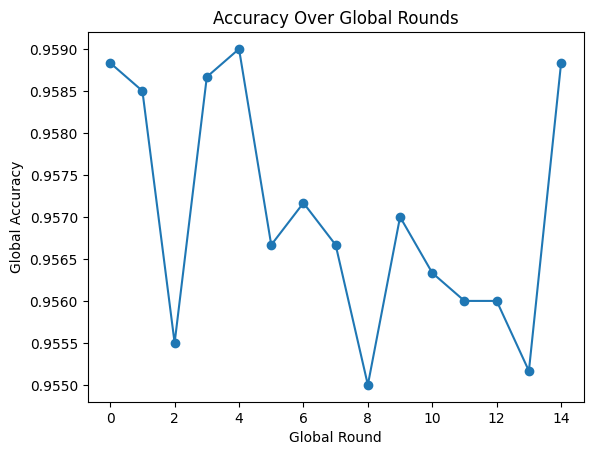

In [36]:
plt.plot(range(max_global_rounds), acc, marker='o')
plt.xlabel("Global Round")
plt.ylabel("Global Accuracy")
plt.title("Accuracy Over Global Rounds")
plt.show()


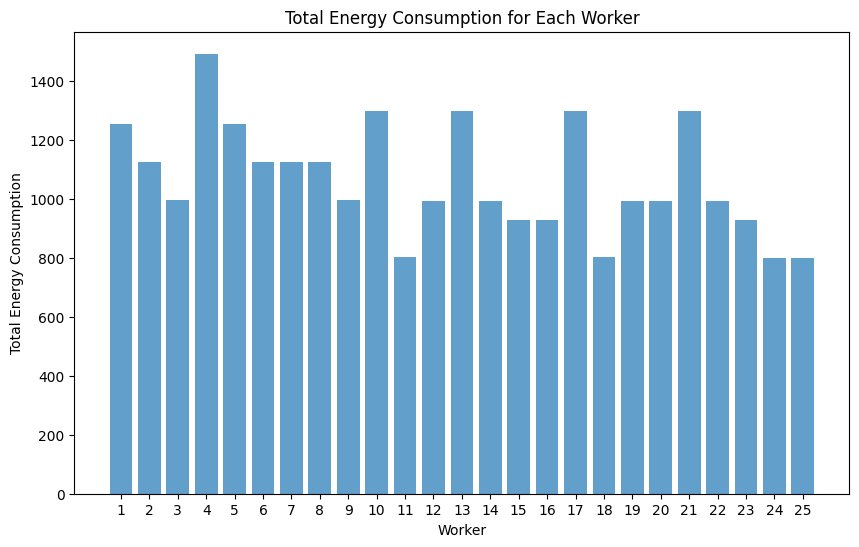

In [37]:
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the total energy consumption for each worker over local rounds
total_energy_per_worker = [sum(workers_info[i][5]) for i in range(num_of_workers)]

# Plotting a bar graph
ax.bar(range(1, num_of_workers + 1), total_energy_per_worker, align='center', alpha=0.7)
ax.set_xticks(range(1, num_of_workers + 1))
ax.set_xlabel('Worker')
ax.set_ylabel('Total Energy Consumption')
ax.set_title('Total Energy Consumption for Each Worker')

plt.show()


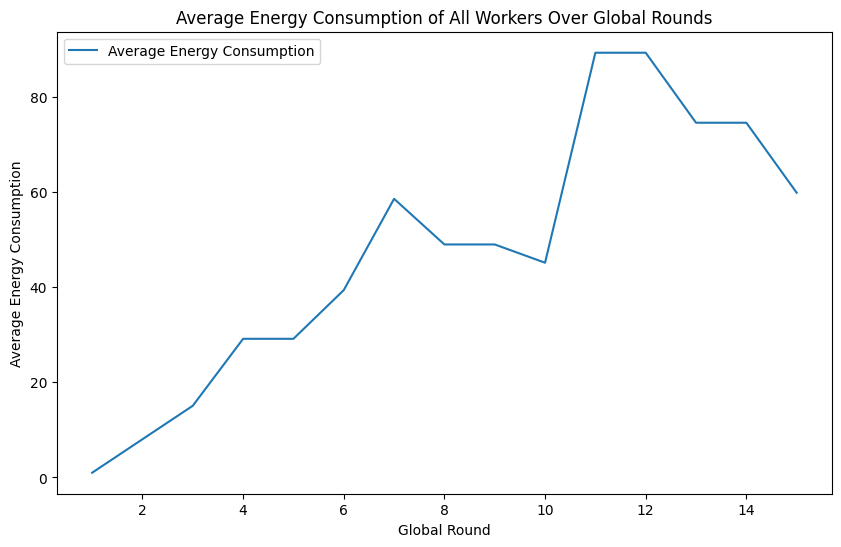

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a list `workers_info` that contains information about each worker's energy consumption

# Calculate the average energy consumption for each global round
average_energy_consumption_per_round = np.mean([worker_info[5][:max_global_rounds] for worker_info in workers_info], axis=0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, max_global_rounds + 1), average_energy_consumption_per_round, label='Average Energy Consumption')
ax.set_xlabel('Global Round')
ax.set_ylabel('Average Energy Consumption')
ax.legend()
plt.title('Average Energy Consumption of All Workers Over Global Rounds')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# ... (Previous code)

# Function to compute average energy decrease
def compute_average_energy_decrease():
    energy_at_start = 10000  # Initial energy value
    average_energy_decrease_per_round = []

    for i in range(max_global_rounds):
        global_model = global_aggregation(global_model)  # Pass the current global_model
        compressed_model = compress(global_model)

        total_energy_decrease = 0

        for j in range(num_of_workers):
            energy_at_end = workers_info[j][7]  # Energy remaining after the global round
            energy_decrease = energy_at_start - energy_at_end
            total_energy_decrease += energy_decrease

        average_energy_decrease = total_energy_decrease / num_of_workers
        average_energy_decrease_per_round.append(average_energy_decrease)

        print("Round - Global", i, "Average Energy Decrease:", average_energy_decrease)

    return average_energy_decrease_per_round

# Call the function to get the average energy decrease values
average_energy_decrease_values = compute_average_energy_decrease()

# Plotting the average energy decrease per round
plt.plot(range(max_global_rounds), average_energy_decrease_values, marker='o')
plt.xlabel("Global Round")
plt.ylabel("Average Energy Decrease")
plt.title("Average Energy Decrease per Global Round")
plt.show()
